# BentoML Example: PyTorch Image Classifier

[BentoML](http://bentoml.ai) is an open source platform for machine learning model serving and deployment. In this project we will use BentoML to package the image classifier model, and build a containerized REST API model server.

This notebook was built based on the official pytorch tutorial https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

![Impression](https://www.google-analytics.com/collect?v=1&tid=UA-112879361-3&cid=555&t=event&ec=nb&ea=open&el=official-example&dt=pytorch-cifar10-image-classification)

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!pip install bentoml
!pip install torch torchvision pillow

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# Training an image classifier

We will do the following steps in order:

* Load and normalizing the CIFAR10 training and test datasets using torchvision
* Define a Convolutional Neural Network
* Define a loss function
* Train the network on the training data
* Test the network on the test data
* Model Serving with BentoML


## 1 Loading and Normalizing CIFAR10

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.

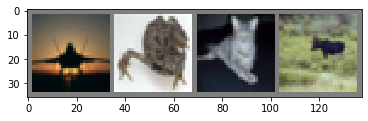

plane  frog   cat  deer


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2 Define a Convolutional Neural Network

Copy the neural network from the Neural Networks section before and modify it to take 3-channel images (instead of 1-channel images as it was defined).

In [9]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

## 3 Define a Loss function and optimize

Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4 Train the network

This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [11]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.217
[1,  4000] loss: 1.873
[1,  6000] loss: 1.685
[1,  8000] loss: 1.616
[1, 10000] loss: 1.554
[1, 12000] loss: 1.487
[2,  2000] loss: 1.410
[2,  4000] loss: 1.388
[2,  6000] loss: 1.371
[2,  8000] loss: 1.337
[2, 10000] loss: 1.305
[2, 12000] loss: 1.274
Finished Training


## 5 Test the network on the test data

We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

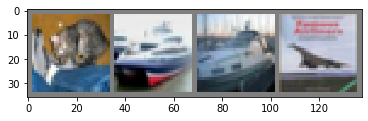

GroundTruth:    cat  ship  ship plane


In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Let us look at how the network performs on the whole dataset.

In [13]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


# 6 Model Serving with BentoML


First, define ML service with BentoML

In [19]:
%%writefile pytorch_image_classifier.py

from PIL import Image

from torch.autograd import Variable
from torchvision import transforms

import bentoml
from bentoml.artifact import PytorchModelArtifact
from bentoml.handlers import ImageHandler


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

@bentoml.env(pip_dependencies=['torch', 'numpy', 'torchvision', 'scikit-learn'])
@bentoml.artifacts([PytorchModelArtifact('net')])
class ImageClassifier(bentoml.BentoService):
    @bentoml.api(ImageHandler)
    def predict(self, img):
        img = Image.fromarray(img).resize((32, 32))
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

        input_data = transform(img)

        outputs = self.artifacts.net(Variable(input_data).unsqueeze(0))
        _, output_classes = outputs.max(dim=1)

        return classes[output_classes]

Overwriting pytorch_image_classifier.py


Now you can instantiate a BentoService defined above with the trained model, and save the entire BentoService to a file archive:

In [15]:
# 1) import the custom BentoService defined above
from pytorch_image_classifier import ImageClassifier

# 2) `pack` it with required artifacts
bento_service = ImageClassifier.pack(net=net)

# 3) save your BentoSerivce to file archive
saved_path = bento_service.save()

[2019-09-19 13:23:57,907] INFO - Successfully saved Bento 'ImageClassifier:2019_09_19_0440d952' to path: /Users/chaoyuyang/bentoml/repository/ImageClassifier/2019_09_19_0440d952


## Test saved BentoService from CLI

In [16]:
!pip install {saved_path}

Processing /Users/chaoyuyang/bentoml/repository/ImageClassifier/2019_09_19_0440d952
  Stored in directory: /private/var/folders/ns/vc9qhmqx5dx_9fws7d869lqh0000gn/T/pip-ephem-wheel-cache-z10he422/wheels/aa/8f/e8/d9ee81c1ff813530d961883d7d5e25e4e08ab74927e3c0913b
Successfully built ImageClassifier


In [17]:
!ImageClassifier predict --input=bird.jpg

bird


## Model Serving via REST API

In your termnial, run the following command to start the REST API server:

In [18]:
!bentoml serve {saved_path}

 * Serving Flask app "ImageClassifier" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [19/Sep/2019 13:26:28] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [19/Sep/2019 13:31:05] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [19/Sep/2019 13:31:06] "GET /docs.json HTTP/1.1" 200 -
^C


Open a terminal and go to the directory of the current notebook, then run the following command to evaluate.

```bash
curl -X POST "http://127.0.0.1:5000/predict" -H "Content-Type: image/*" --data-binary "@bird.jpg"
```

alternatively:
```bash
curl -X POST "http://127.0.0.1:5000/predict" -F image=@bird.png
```


Go visit http://127.0.0.1:5000/ from your browser, click `/predict` -> `Try it out` -> `Choose File` -> `Execute` to sumbit an image from your computer